## Import needed modules

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import h5py
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


## Set image size

In [2]:
img_width, img_height = 128, 128

## Prepare datageneretors for images loading

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    './dogs-vs-cats/train',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    './dogs-vs-cats/test',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary')

Found 24000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Now, let's look at few photos from dataset

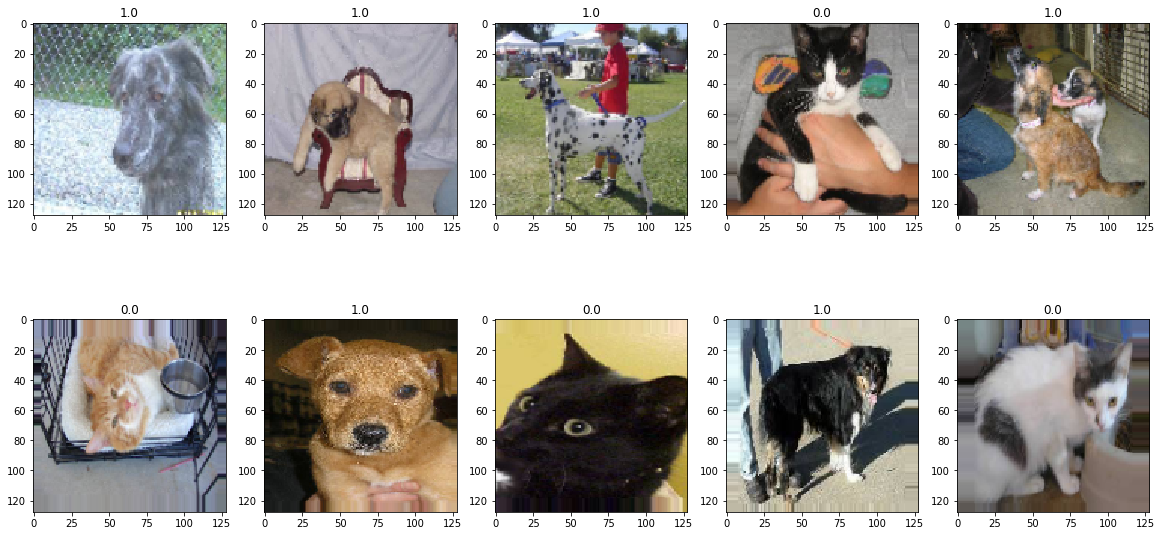

In [4]:
images, labels = train_generator.next()
rows = 2
cols = 5

fig, ax = plt.subplots(rows, cols, figsize=(20, 10))
for row in range(rows):
    for col in range(cols):
        ax[row, col].set_title(str(labels[row*cols + col]))
        ax[row, col].imshow(images[row*cols + col])
plt.show()

train_generator.reset()

## Get trained VGG16 model without dense layers with proper input_shape and freeze it's weight

In [5]:
# download model from keras.appliactions
# remove dense layers on top of it
vgg = tf.keras.applications.VGG16(input_shape=(img_width, img_height, 3),
                                  include_top=False,
                                  weights='imagenet')
# freeze weights to avoid changing trained layers

In [6]:
vgg.trainable=False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## Build new model on top of VGG conv layers
### We want our model to have 2 layers:

- 128 neurons, ReLU as activation function
- 1 neuron, Sigmoid as activation function, because we want our output to be in <0; 1> range

In [7]:
# add 2 dense layers on top of vgg model
model = tf.keras.Sequential([
    vgg,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

## Compile model with Adam as optimizer with lr = 0.001 and binary_crossentropy loss

In [8]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


## Train model on dataset from train_generator (2 epochs)

In [ ]:
# call fit_generator method with proper arguments
model.fit_generator(train_generator, validation_data=test_generator, epochs=2)

Epoch 1/2
  1/750 [..............................] - ETA: 4:25:01 - loss: 0.7756 - accuracy: 0.3750

## Evaluate model on unseen data

In [ ]:
model.evaluate_generator(test_generator)